# STEP 1: PREP WORK & VISUALIZATION FOR GAN

In [1]:
import os
image_folder = os.path.join("..", "PokemonGenerator", "png_dataset")

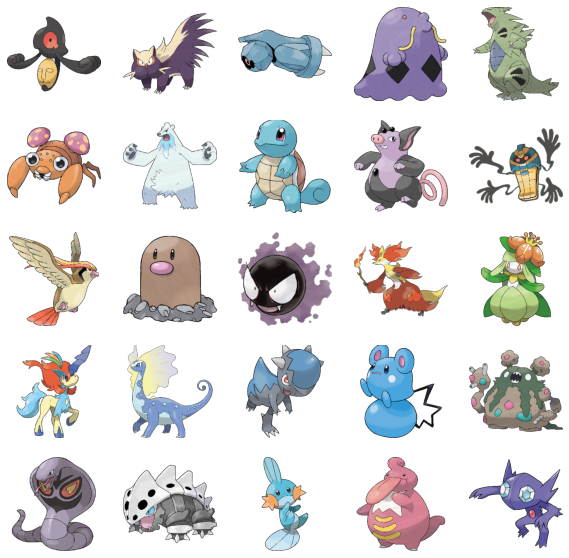

In [2]:

import random
import matplotlib.pyplot as plt
from PIL import Image

# Load image paths
image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)]

# Randomly sample image paths
sample_size = 25
sample_paths = random.sample(image_paths, sample_size)

# Load and display images in a grid
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
axes = axes.ravel()

for i, path in enumerate(sample_paths):
    img = Image.open(path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.show()

#First check is done, as we have started by visualizing the data to check the quality of the images

# STEP 2: DATA AUGMENTATION 

2023-04-25 11:17:13.700416: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


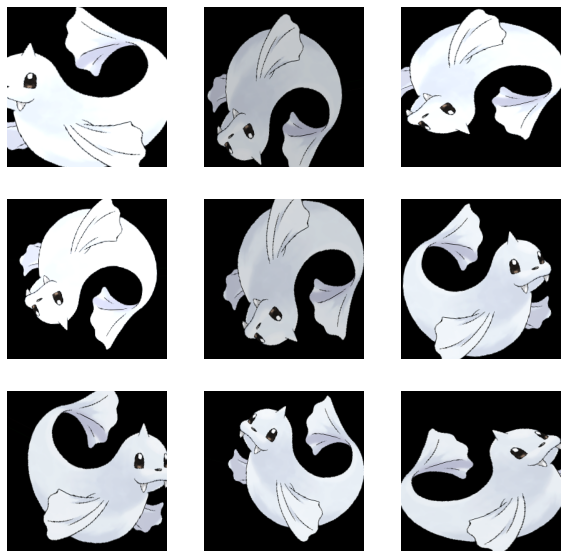

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import random

# Define the data augmentation pipeline using ImageDataGenerator
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    zoom_range=[0.8, 1.2]
)

# Load a sample image to try and preprocess it
val = random.randint(1, 721)
file = os.path.join(image_folder, str(val) +".png")
image = load_img(file)  # Load image
image = img_to_array(image)   # Convert to NumPy array
image = np.expand_dims(image, axis=0)  # Add batch dimension

# Apply data augmentation to the sample image
augmented_images = []
batch_size = 9

for batch in datagen.flow(image, batch_size=batch_size):
    augmented_images.append(batch[0])
    if len(augmented_images) >= batch_size:
        break

# Visualize the augmented images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()

for i, img in enumerate(augmented_images):
    axes[i].imshow(img)
    axes[i].axis('off')

plt.show()

>
>**This seems to be working pretty well. When integrating this pipeline into our training process, we can replace the sample image with our entire dataset, and feed the augmented images to the GAN during training!!**
>> To do this we just need to call *datagen.flow()* on our dataset when feeding images to the GAN during training.

# STEP 3: PREPROCESS THE DATA FOR MODEL

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Conv2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, LeakyReLU, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from IPython import display

In [5]:
#image_folder = "../PokemonGenerator/png_dataset"
image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]
# Creating a list of image file paths by combining the image_folder path with the filenames of all images in the folder
# By creating a list of file paths, we can easily iterate over them and load each image in the load_image() function, which processes and prepares the images for training the GAN model

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3) # Decode PNG-encoded image data and PNG images usually have 3 color channels
    image = tf.image.resize(image, (64, 64)) # resize
    image = tf.image.random_flip_left_right(image)  # data augmentation...we can apply more if needed
    image = tf.image.convert_image_dtype(image, tf.float32) * 2.0 - 1.0
    # Converts the input image's pixel values to the range [0, 1] 
    # Then, we multiply the pixel values by 2 and subtract 1 to scale them to the range of -1 to 1
    # Normalizing the input images to the range of -1 to 1 is important since GAN uses a tanh activation function in its output layer
    # where it produces values in the range of -1 to 1.
    # This ensures that the generated images and the real images have the same value range so the discriminator to learn effectively
    return image

# Create a TensorFlow dataset from the list of image file paths
dataset = tf.data.Dataset.from_tensor_slices(image_paths)

# Map the load_image function to each image in the dataset to preprocess them
dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE) 

# Shuffle the dataset and batch the images for training the GAN
dataset = dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

# AUTOTUNE is a parameter in TensorFlow's tf.data API, 
# it allows TensorFlow to automatically determine the optimal number of parallel calls to use for data preprocessing operations
# https://www.tensorflow.org/guide/data_performance

2023-04-25 11:17:18.352228: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Next steps to do: 
 #### 1. Define the generator and discriminator models, 
 #### 2. Create the generator, discriminator, and define the loss functions and optimizers
 #### 3. Define the training step function
 #### 4. Define the training loop
 #### 5. Define the function to generate and save images
 #### 6. Train the DCGAN
>
> *Once the training is complete, we can visualize the generated images and evaluate the performance of the model.*


## Below is what Will did to start off, I did not touch it yet.

In [6]:
from tensorflow.keras import layers, losses
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU, Dropout

For our first pass through we are basing our model on one found here
https://medium.com/mlearning-ai/image-generation-using-generative-adversarial-networks-gans-cd82afd71597

In [7]:
class GAN:  
    def __init__(self, shape):
        self.input_shape = shape
        self.generator = Sequential(
            Dense(256, input_dim=input_shape),
            LeakyReLU(0.2),
            Dense(512),
            LeakyReLU(0.2),
            Dense(1024),
            LeakyReLU(0.2),
            Dense(output_shape, activation='tanh')
        )
        
        self.discriminator = Sequential(
            Dense(1024, input_dim=output_shape),
            LeakyReLU(0.2),
            Dropout(0.2),
            Dense(512),
            LeakyReLU(0.2),
            Dropout(0.2),
            Dense(256),
            LeakyReLU(0.2),
            Dense(1, activation='sigmoid')
        )
        
    